# Project 4: Movie Recommender System


## Nikhil Sarin


# Project Setup
This notebook expects the following directory structure:

    project-4/
        data/
            ratings.dat
            movies.dat
            users.dat
            Rmat.csv
            verification/
                Step2Output-10Rows.csv
                Step3Output-10Rows.csv
            MovieImages/
                1.jpg
                2.jpg
                ...
        notebooks/
            project-4.ipynb

Please ensure all data files are in place before running this notebook. The data files should contain:
- `ratings.dat`: MovieLens user ratings data
- `movies.dat`: MovieLens movie information
- `users.dat`: MovieLens user information
- `Rmat.csv`: Pre-processed ratings matrix
- `verification/*.csv`: Verification files for IBCF implementation
- `MovieImages/*.jpg`: Files for Movie Posters

### Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import os

from IPython.display import Image, display

In [2]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, 'data')
VERIFICATION_DIR = os.path.join(DATA_DIR, 'verification')

required_files = [
    os.path.join(DATA_DIR, 'ratings.dat'),
    os.path.join(DATA_DIR, 'movies.dat'),
    os.path.join(DATA_DIR, 'users.dat'),
    os.path.join(DATA_DIR, 'Rmat.csv'),
    os.path.join(VERIFICATION_DIR, 'Step2Output-10Rows.csv'),
    os.path.join(VERIFICATION_DIR, 'Step3Output-10Rows.csv')
]

missing_files = [f for f in required_files if not os.path.exists(f)]
if missing_files:
    print("Missing required files:")
    for f in missing_files:
        print(f"  - {f}")
    raise FileNotFoundError("Required data files are missing")

print("All required data files found!")

All required data files found!


In [3]:
class MovieDataLoader:
    def __init__(self):
        self.ratings_df = None
        self.movies_df = None
        self.users_df = None
        self.ratings_matrix = None

    def load_raw_data(self, ratings_path, movies_path, users_path):
        """Load the original MovieLens data files"""
        self.ratings_df = pd.read_csv(ratings_path, 
                                    sep='::', 
                                    engine='python',
                                    encoding='latin1',
                                    names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
        
        with open(movies_path, 'r', encoding='latin1') as f:
            movies_lines = f.readlines()
        
        movies_data = []
        for line in movies_lines:
            movieID, title, genres = line.strip().split('::')
            movies_data.append([int(movieID), title, genres])
        
        self.movies_df = pd.DataFrame(movies_data, columns=['MovieID', 'Title', 'Genres'])
        
        self.users_df = pd.read_csv(users_path,
                                  sep='::', 
                                  engine='python',
                                  encoding='latin1',
                                  names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
        
        return self.ratings_df, self.movies_df, self.users_df

    def load_rating_matrix(self, matrix_path):
        """Load the pre-processed rating matrix"""
        self.ratings_matrix = pd.read_csv(matrix_path, index_col=0)
        return self.ratings_matrix

    def get_movie_stats(self):
        """Calculate basic statistics for each movie"""
        if self.ratings_df is None:
            raise ValueError("Raw ratings data not loaded yet")
            
        movie_stats = self.ratings_df.groupby('MovieID').agg({
            'Rating': ['count', 'mean', 'std']
        }).reset_index()
        
        movie_stats.columns = ['MovieID', 'rating_count', 'rating_mean', 'rating_std']
        movie_stats = movie_stats.merge(self.movies_df[['MovieID', 'Title']], on='MovieID')
        
        return movie_stats

    def create_rating_matrix(self):
        """Create rating matrix from raw ratings data"""
        if self.ratings_df is None:
            raise ValueError("Raw ratings data not loaded yet")
            
        matrix = self.ratings_df.pivot(
            index='UserID',
            columns='MovieID',
            values='Rating'
        )
        
        matrix.columns = [f'm{col}' for col in matrix.columns]
        matrix.index = [f'u{idx}' for idx in matrix.index]
        
        self.ratings_matrix = matrix
        return matrix

    def save_rating_matrix(self, save_path):
        """Save rating matrix to CSV"""
        if self.ratings_matrix is not None:
            self.ratings_matrix.to_csv(save_path)

## System I: Recommendation Based on Popularity

### Popularity Score Calculation

The popularity score for each movie is calculated using both the quantity and quality of ratings, ensuring that popular movies are both well-rated and have sufficient viewer feedback. Here's how we calculate it:

1. **Quantity Threshold**:
   - Calculate the median number of ratings across all movies
   - Only consider movies that have more than the median number of ratings
   - This ensures we have enough ratings to make reliable judgments

2. **Quality Metric**:
   - Use the mean rating for each movie
   - This captures how well-received the movie is by users who watched it

3. **Final Score**:
   - For movies with more than median ratings:
     - Popularity Score = Mean Rating
   - For movies with less than or equal to median ratings:
     - Popularity Score = 0
   
This approach:
- Filters out movies with too few ratings to be considered "popular"
- Prioritizes movies that are both highly rated and widely watched
- Avoids recommending movies that might be highly rated but only by a small number of users

Example:
- If a movie has 500 ratings (above median) and an average rating of 4.5, its popularity score would be 4.5
- If a movie has only 10 ratings (below median) but an average rating of 5.0, its popularity score would be 0

In [4]:
class PopularityRecommender:
    def __init__(self):
        self.data_loader = MovieDataLoader()
        self.movie_stats = None
        
    def fit(self, ratings_path, movies_path, users_path):
        """
        Train the popularity based recommender
        """
        self.data_loader.load_raw_data(ratings_path, movies_path, users_path)
        
        self.movie_stats = self.data_loader.get_movie_stats()
        
        median_ratings = self.movie_stats['rating_count'].median()
        
        self.movie_stats['popularity_score'] = (
            self.movie_stats['rating_mean'] * 
            (self.movie_stats['rating_count'] > median_ratings)
        )
        
        self.movie_stats.loc[self.movie_stats['rating_count'] <= median_ratings, 'popularity_score'] = 0
        
    def get_top_n_movies(self, n=10):
        """Get the top n most popular movies"""
        if self.movie_stats is None:
            raise ValueError("Please fit the recommender first using fit()")
            
        top_movies = (self.movie_stats
                     .nlargest(n, 'popularity_score')
                     .copy())
        
        recommendations = top_movies.apply(
            lambda x: {
                'MovieID': f"m{int(x['MovieID'])}",
                'Title': x['Title'],
                'Rating': round(x['rating_mean'], 2),
                'Number_of_Ratings': int(x['rating_count'])
            }, axis=1
        ).tolist()
        
        return recommendations

## System II: IBCF Recommender

In [5]:
class IBCFRecommender:
    def __init__(self):
        self.data_loader = MovieDataLoader()
        self.similarity_matrix = None
        self.ratings_matrix = None
        self.movies_df = None
        self.centered_ratings = None
        
    def verify_first_rows_centering(self, centered_data):
        """Verify the first 10 rows of centered data match expected values"""
        print("\nVerifying First 10 Rows of Centered Matrix:")
        print("-" * 50)
        
        centered_df = pd.DataFrame(
            centered_data,
            index=self.ratings_matrix.index,
            columns=self.ratings_matrix.columns
        )
        
        expected_values = {
            ('u1', 'm1'): 0.8113208,
            ('u10', 'm1'): 0.8852868,
            ('u100', 'm1'): np.nan,
            ('u1000', 'm1'): 0.8690476,
            ('u1001', 'm1'): 0.3474801,
            ('u999', 'm1003'): -1.1868932,
            ('u999', 'm1004'): -0.1868932,
            ('u996', 'm999'): -0.9358108
        }
        
        print("\nComparing values:")
        for (user, movie), expected in expected_values.items():
            actual = centered_df.loc[user, movie]
            if np.isnan(expected):
                is_match = np.isnan(actual)
            else:
                is_match = np.abs(actual - expected) < 0.0001
            
            print(f"{user}, {movie}:")
            print(f"  Expected: {expected}")
            print(f"  Actual: {actual}")
            print(f"  Match: {is_match}")
            print()
        
    def verify_similarities_step2(self, computed_similarity_matrix):
        """Verify similarity computations against provided CSV file"""
        print("\nStep 2 Verification - Comparing Similarity Matrix:")
        print("-" * 50)
        
        expected_df = pd.read_csv(os.path.join(self.verification_path, 'Step2Output-10Rows.csv'), index_col=0)
        
        specific_ids = ['m1', 'm10', 'm100', 'm1510', 'm260', 'm3212']
        specific_indices = [self.column_to_index[mid] for mid in specific_ids]
        
        specific_df = pd.DataFrame(
            computed_similarity_matrix[np.ix_(specific_indices, specific_indices)],
            index=specific_ids,
            columns=specific_ids
        )
        
        print("\nSpecified Movies Similarity Matrix:")
        print(specific_df.round(7))
        
        movie_ids = expected_df.index.tolist()
        indices = [self.column_to_index[mid] for mid in movie_ids]
        
        computed_df = pd.DataFrame(
            computed_similarity_matrix[np.ix_(indices, indices)],
            index=movie_ids,
            columns=movie_ids
        )
        
        print("\nComparing all similarity values:")
        mismatches = []
        total_comparisons = 0
        nan_matches = 0
        
        for i in movie_ids:
            for j in movie_ids:
                total_comparisons += 1
                expected = expected_df.loc[i, j]
                computed = computed_df.loc[i, j]
                
                if pd.isna(expected) and pd.isna(computed):
                    nan_matches += 1
                    continue
                elif pd.isna(expected) != pd.isna(computed):
                    mismatches.append((i, j, expected, computed, "NaN mismatch"))
                elif abs(expected - computed) > 1e-7:
                    mismatches.append((i, j, expected, computed, "Value mismatch"))
        
        print(f"\nTotal comparisons: {total_comparisons}")
        print(f"NaN matches: {nan_matches}")
        print(f"Non-NaN comparisons: {total_comparisons - nan_matches}")
        
        if not mismatches:
            print("All checked values match within tolerance!")
        else:
            print("\nMismatches found:")
            print("MovieID1  MovieID2  Expected      Computed      Type")
            print("-" * 60)
            for m1, m2, exp, comp, type_mismatch in mismatches:
                if pd.isna(exp):
                    print(f"{m1:8} {m2:8}       nan    {comp:12.7f} {type_mismatch}")
                elif pd.isna(comp):
                    print(f"{m1:8} {m2:8} {exp:12.7f}          nan {type_mismatch}")
                else:
                    print(f"{m1:8} {m2:8} {exp:12.7f} {comp:12.7f} {type_mismatch}")
        
        self.similarity_matrix = computed_similarity_matrix
        return len(mismatches) == 0
    
    def verify_similarities_step3(self, filtered_similarity_matrix):
        """Verify the top-30 filtering results"""
        print("\nStep 3 Verification - Comparing Filtered Matrix:")
        print("-" * 50)
        
        expected_df = pd.read_csv(os.path.join(self.verification_path, 'Step3Output-10Rows.csv'), index_col=0)
        
        movie_ids = ['m1', 'm10', 'm100', 'm1000', 'm1002', 'm1003', 'm1004', 'm1005', 'm1006', 'm1007']
        indices = [self.column_to_index[mid] for mid in movie_ids]
        
        computed_df = pd.DataFrame(
            filtered_similarity_matrix[np.ix_(indices, indices)],
            index=movie_ids,
            columns=movie_ids
        )
        
        print("\nComparing filtered similarity values:")
        mismatches = []
        nan_matches = 0
        total_comparisons = 0
        
        for i in movie_ids:
            for j in movie_ids:
                expected = expected_df.loc[i, j]
                computed = computed_df.loc[i, j]
                total_comparisons += 1
                
                if pd.isna(expected) and pd.isna(computed):
                    nan_matches += 1
                    continue
                    
                if pd.isna(expected) != pd.isna(computed):
                    mismatches.append((i, j, expected, computed, "NaN mismatch"))
                elif not pd.isna(expected) and not pd.isna(computed):
                    if abs(expected - computed) > 1e-7:
                        mismatches.append((i, j, expected, computed, "Value mismatch"))
        
        print(f"\nTotal comparisons: {total_comparisons}")
        print(f"NaN matches: {nan_matches}")
        print(f"Non-NaN comparisons: {total_comparisons - nan_matches}")
        
        if mismatches:
            print("\nMismatches found:")
            print("MovieID1  MovieID2  Expected      Computed      Type")
            print("-" * 60)
            for m1, m2, exp, comp, type_mismatch in mismatches:
                if pd.isna(exp):
                    print(f"{m1:8} {m2:8}       nan    {comp:12.7f} {type_mismatch}")
                elif pd.isna(comp):
                    print(f"{m1:8} {m2:8} {exp:12.7f}          nan {type_mismatch}")
                else:
                    print(f"{m1:8} {m2:8} {exp:12.7f} {comp:12.7f} {type_mismatch}")
        else:
            print("\nAll checked values match within tolerance!")
            
        print("\nFiltered Similarity Matrix (First 5x5):")
        print(computed_df.iloc[:5, :5].round(7))

        m1000_idx = self.column_to_index['m1000']
        m1021_idx = self.column_to_index['m1021']
        actual_value = filtered_similarity_matrix[m1000_idx, m1021_idx]
        expected_value = 0.9700115756880312
        
        print("\nChecking specific value (m1000, m1021):")
        print(f"Expected: {expected_value:.7f}")
        print(f"Actual:   {actual_value:.7f}")
        print(f"Match:    {abs(actual_value - expected_value) < 1e-7}")
        
        non_nan_counts = np.sum(~np.isnan(filtered_similarity_matrix), axis=1)
        max_non_nan = np.max(non_nan_counts)
        print(f"\nMaximum non-NaN values for any movie: {max_non_nan}")
        if max_non_nan > 30:
            print("WARNING: Some movies have more than 30 similarities!")
            
        return len(mismatches) == 0 and max_non_nan <= 30
        
    def fit(self, ratings_matrix_path, movies_path):
        """Train the IBCF recommender with verification steps"""
        print("Loading data...")
        self.ratings_matrix = self.data_loader.load_rating_matrix(ratings_matrix_path)
        
        self.column_to_index = {col: idx for idx, col in enumerate(self.ratings_matrix.columns)}
        self.index_to_column = {idx: col for col, idx in self.column_to_index.items()}
        
        ratings_array = self.ratings_matrix.values.astype(np.float32)
        n_movies = ratings_array.shape[1]
        
        print("Data loaded successfully.")
        
        print("\nStep 1: Centering the Rating Matrix")
        row_means = np.nanmean(ratings_array, axis=1, keepdims=True)
        centered_ratings = np.full_like(ratings_array, np.nan)
        for i in range(ratings_array.shape[0]):
            mask = ~np.isnan(ratings_array[i, :])
            if np.any(mask):
                centered_ratings[i, mask] = ratings_array[i, mask] - row_means[i]

        self.centered_ratings = centered_ratings
        
        self.verify_first_rows_centering(centered_ratings)
        
        print("\nStep 2: Computing Similarity Matrix")
        similarity_matrix = np.full((n_movies, n_movies), np.nan)
        
        for i in range(n_movies):
            for j in range(i+1, n_movies):
                mask = ~np.isnan(ratings_array[:, i]) & ~np.isnan(ratings_array[:, j])
                common_users = np.sum(mask)
                
                if common_users > 2:
                    ratings_i = centered_ratings[mask, i]
                    ratings_j = centered_ratings[mask, j]
                    
                    numerator = np.sum(ratings_i * ratings_j)
                    denom_i = np.sqrt(np.sum(ratings_i**2))
                    denom_j = np.sqrt(np.sum(ratings_j**2))
                    denominator = denom_i * denom_j
                    
                    if denominator > 0:
                        sim = 0.5 + 0.5 * (numerator / denominator)
                        similarity_matrix[i, j] = sim
                        similarity_matrix[j, i] = sim
        
        np.fill_diagonal(similarity_matrix, np.nan)
        
        verification_passed = self.verify_similarities_step2(similarity_matrix)
        if not verification_passed:
            print("\nWARNING: Similarity matrix computation may need adjustment!")
        else:
            print("\nSimilarity matrix verification passed!")
        
        print("\nStep 3: Applying Top-30 Filtering")
        filtered_similarity_matrix = similarity_matrix.copy()

        for i in range(n_movies):
            similarities = filtered_similarity_matrix[i, :]
            non_nan_indices = np.where(~np.isnan(similarities))[0]
            
            if len(non_nan_indices) > 30:
                non_nan_sims = similarities[non_nan_indices]
                sorted_indices = np.argsort(-non_nan_sims)
                keep_indices = non_nan_indices[sorted_indices[:30]]
                filtered_similarity_matrix[i, :] = np.nan
                filtered_similarity_matrix[i, keep_indices] = similarity_matrix[i, keep_indices]

        self.similarity_matrix = filtered_similarity_matrix

        verification_passed = self.verify_similarities_step3(filtered_similarity_matrix)

        if not verification_passed:
            print("\nWARNING: Top-30 filtering may need adjustment!")
        else:
            print("\nTop-30 filtering verification passed!")

        return filtered_similarity_matrix

    def predict(self, user_vector):
        """Generate predictions for a user vector using IBCF"""
        if self.similarity_matrix is None:
            raise ValueError("Please fit the recommender first using fit()")
            
        predictions = np.zeros(len(user_vector))
        
        rated_indices = np.where(~np.isnan(user_vector) & (user_vector > 0))[0]
        
        for i in range(len(user_vector)):
            if np.isnan(user_vector[i]) or user_vector[i] == 0:
                weighted_sum = 0
                sum_similarities = 0
                
                for rated_idx in rated_indices:
                    sim = self.similarity_matrix[i, rated_idx]
                    if not np.isnan(sim):
                        weighted_sum += sim * user_vector[rated_idx]
                        sum_similarities += sim
                
                if sum_similarities > 0:
                    predictions[i] = weighted_sum / sum_similarities
                else:
                    predictions[i] = np.nan
            else:
                predictions[i] = np.nan
        
        return predictions
    
    def myIBCF(self, newuser):
        """
        Input: newuser - a 3706-by-1 vector containing ratings for the 3,706 movies
        Output: List of top 10 movie IDs with their predicted ratings
        """
        predictions = self.predict(newuser)
        
        pred_series = pd.Series(predictions, index=self.ratings_matrix.columns)
        sorted_preds = pred_series.sort_values(ascending=False)
        non_nan_preds = sorted_preds.dropna()
        
        top_10 = non_nan_preds[:10]
        recommendations = [(movie_id, rating) for movie_id, rating in top_10.items()]
        
        return recommendations

    def test_recommendations(self):
        print("\nTesting Recommendations:")
        print("-" * 50)

        print("\nTest Case 1 - User 1181:")
        user1181_vector = self.ratings_matrix.loc['u1181'].values
        
        ratings_series = pd.Series(user1181_vector, index=self.ratings_matrix.columns)
        print("\nSample of user 1181's top ratings:")
        print(ratings_series[ratings_series > 0].sort_values(ascending=False).head())

        recommendations = self.myIBCF(user1181_vector)
        
        print("\nTop 10 recommendations for User 1181:")
        for movie_id, rating in recommendations:
            print(f"{movie_id}: {rating:.4f}")

        print("\nTest Case 2 - Hypothetical User (m1613: 5, m1755: 4):")
        hypo_user_vector = np.zeros(len(self.ratings_matrix.columns))
        hypo_user_vector[self.column_to_index['m1613']] = 5
        hypo_user_vector[self.column_to_index['m1755']] = 4
        
        recommendations2 = self.myIBCF(hypo_user_vector)
        
        print("\nTop 10 recommendations for Hypothetical User:")
        for movie_id, rating in recommendations2:
            print(f"{movie_id}: {rating:.4f}")

### Testing and Results


Top 10 Movie Recommendations:
--------------------------------------------------------------------------------
1. Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)
   MovieID: m2019
   Average Rating: 4.56
   Number of Ratings: 628


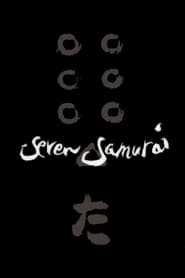


2. Shawshank Redemption, The (1994)
   MovieID: m318
   Average Rating: 4.55
   Number of Ratings: 2227


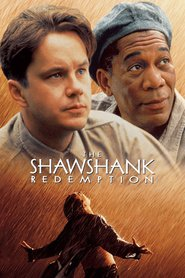


3. Godfather, The (1972)
   MovieID: m858
   Average Rating: 4.52
   Number of Ratings: 2223


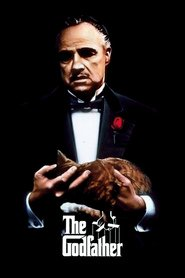


4. Close Shave, A (1995)
   MovieID: m745
   Average Rating: 4.52
   Number of Ratings: 657


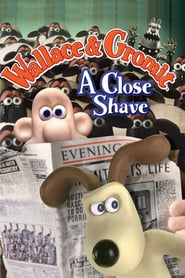


5. Usual Suspects, The (1995)
   MovieID: m50
   Average Rating: 4.52
   Number of Ratings: 1783


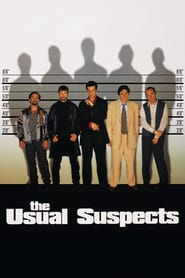


6. Schindler's List (1993)
   MovieID: m527
   Average Rating: 4.51
   Number of Ratings: 2304


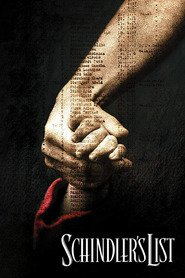


7. Wrong Trousers, The (1993)
   MovieID: m1148
   Average Rating: 4.51
   Number of Ratings: 882


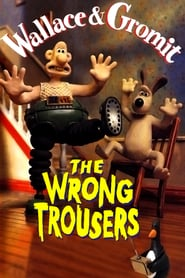


8. Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
   MovieID: m922
   Average Rating: 4.49
   Number of Ratings: 470


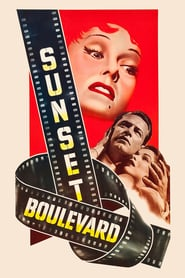


9. Raiders of the Lost Ark (1981)
   MovieID: m1198
   Average Rating: 4.48
   Number of Ratings: 2514


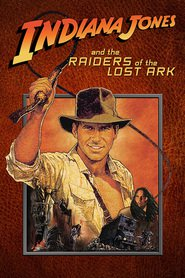


10. Rear Window (1954)
   MovieID: m904
   Average Rating: 4.48
   Number of Ratings: 1050


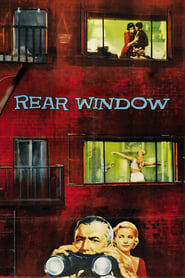

In [6]:
recommender = PopularityRecommender()

DATA_DIR = "../data"
IMAGES_DIR = os.path.join(DATA_DIR, "MovieImages")

recommender.fit(
    os.path.join(DATA_DIR, 'ratings.dat'),
    os.path.join(DATA_DIR, 'movies.dat'),
    os.path.join(DATA_DIR, 'users.dat')
)

top_movies = recommender.get_top_n_movies(10)

print("\nTop 10 Movie Recommendations:")
print("-" * 80)
for i, movie in enumerate(top_movies, 1):
    print(f"{i}. {movie['Title']}")
    print(f"   MovieID: {movie['MovieID']}")
    print(f"   Average Rating: {movie['Rating']}")
    print(f"   Number of Ratings: {movie['Number_of_Ratings']}")
    
    movie_id = movie['MovieID'][1:]
    
    try:
        image_path = os.path.join(IMAGES_DIR, f"{movie_id}.jpg")
        if os.path.exists(image_path):
            display(Image(filename=image_path, width=200))
        else:
            print(f"   [No poster available for {movie['MovieID']}]")
    except Exception as e:
        print(f"   [Error loading poster for {movie['MovieID']}: {e}]")
    
    print()

In [7]:
recommender = IBCFRecommender()
recommender.verification_path = os.path.join(DATA_DIR, 'verification')

recommender.fit(
    os.path.join(DATA_DIR, 'Rmat.csv'), 
    os.path.join(DATA_DIR, 'movies.dat')
)

recommender.test_recommendations()

Loading data...
Data loaded successfully.

Step 1: Centering the Rating Matrix

Verifying First 10 Rows of Centered Matrix:
--------------------------------------------------

Comparing values:
u1, m1:
  Expected: 0.8113208
  Actual: 0.8113207817077637
  Match: True

u10, m1:
  Expected: 0.8852868
  Actual: 0.885286808013916
  Match: True

u100, m1:
  Expected: nan
  Actual: nan
  Match: True

u1000, m1:
  Expected: 0.8690476
  Actual: 0.8690476417541504
  Match: True

u1001, m1:
  Expected: 0.3474801
  Actual: 0.34748005867004395
  Match: True

u999, m1003:
  Expected: -1.1868932
  Actual: -1.1868932247161865
  Match: True

u999, m1004:
  Expected: -0.1868932
  Actual: -0.18689322471618652
  Match: True

u996, m999:
  Expected: -0.9358108
  Actual: -0.9358108043670654
  Match: True


Step 2: Computing Similarity Matrix

Step 2 Verification - Comparing Similarity Matrix:
--------------------------------------------------

Specified Movies Similarity Matrix:
             m1       m10   